In [1]:
import numpy as np
import pandas as pd

path = "avg/"
sub_path = "d7/500-dmsp.xlsx"

host_path = "data/algae/" + path + sub_path
bacteria_path = "data/bacteria/" + path + sub_path

df_host = pd.read_excel(host_path, header=None)
df_bacteria = pd.read_excel(bacteria_path, header=None)
df_bacteria = df_bacteria.replace(0, np.nan)

df_host_time = df_host.iloc[:, 0]
host = df_host.iloc[:, 1].tolist()

df_bacteria_time = df_bacteria.iloc[:, 0]
bacteria = df_bacteria.iloc[:, 1].tolist()

time = df_host_time.tolist()
#time = time[1:]

log_host = np.log(np.array(host) + 1e-9)
log_bacteria = np.log(np.array(bacteria) + 1e-9)

save_path = "figures/full/" + host_path.replace("/", "_")
save_path = save_path[:-5].replace("data_algae_", "").strip()


In [2]:
def ode_system(t, y, params):
    H = y[0]
    B = y[1]
    P = y[2]

    muH = params[0]
    muB = params[1]
    k = params[2]
    phi = params[3]
    beta = params[4]

    dHdt = (muH * H * (1 - (H / k) )) - phi * H * P
    dPdt = beta * phi * H * P
    dBdt = muB * B
    return [dHdt, dBdt, dPdt]

In [3]:
import pytensor.tensor as pt
from pytensor.graph.op import Op
from scipy.integrate import solve_ivp

class SolveIVPWrapper(Op):
    itypes = [pt.dvector]  # theta + y0
    otypes = [pt.dmatrix]  # solution: (len(t), 3)

    def __init__(self, times):
        self.times = times

    def perform(self, node, inputs, outputs):
        theta_y0, = inputs
        theta = theta_y0[:5] # first 5
        y0 = theta_y0[5:] # last 3

        sol = solve_ivp(
            fun=lambda t, y: ode_system(t, y, theta),
            t_span=(self.times[0], self.times[-1]),
            y0=y0,
            t_eval=self.times,
            method="LSODA"
        )

        if not sol.success:
            raise RuntimeError("ODE solver failed:", sol.message)

        outputs[0][0] = sol.y.T  # shape: (time, 3)

In [4]:
import pymc as pm

ode_op = SolveIVPWrapper(time)

with pm.Model() as model:
    muH = pm.Lognormal("muH", mu=np.log(0.76), sigma=.5)
    muB = pm.Uniform("muB", lower=0, upper=1)
    k = pm.Lognormal("k", mu=np.log(4.9e6), sigma=.5)
    phi = pm.Lognormal("phi", mu=np.log(7.1e-9), sigma=0.5)
    beta = pm.Uniform("beta", lower=0, upper=100)

    H0 = pm.Uniform("H0", lower=2e5, upper=1e7)
    B0 = pm.Uniform("B0", lower=2e4, upper=1e7)
    P0 = pm.Uniform("P0", lower=2e5, upper=6e7)
    
    sigma_host = pm.HalfNormal("sigma_host", sigma=1)
    sigma_bacteria = pm.HalfNormal("sigma_bacteria", sigma=1)

    ode_solution = ode_op(pt.stack([muH, muB, k, phi, beta, H0, B0, P0]))

    pm.Normal(
        "host_obs",
        mu=pm.math.log(ode_solution[:, 0] + 1e-9),
        sigma=sigma_host,
        observed=log_host
    )

    pm.Normal(
        "bacteria_obs",
        mu=pm.math.log(ode_solution[:, 1] + 1e-9),
        sigma=sigma_bacteria,
        observed=log_bacteria
    )

In [5]:
with model:
    trace = pm.sample(draws=20000, 
                      tune=20000, 
                      step=pm.Metropolis(),
                      chains=4, 
                      cores=4, 
                      return_inferencedata=True, 
                     ) 

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [muH]
>Metropolis: [muB]
>Metropolis: [k]
>Metropolis: [phi]
>Metropolis: [beta]
>Metropolis: [H0]
>Metropolis: [B0]
>Metropolis: [P0]
>Metropolis: [sigma_host]
>Metropolis: [sigma_bacteria]


Output()

Sampling 4 chains for 20_000 tune and 20_000 draw iterations (80_000 + 80_000 draws total) took 537 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [6]:
import arviz as az
import matplotlib.pyplot as plt
summary = az.summary(
    trace,
    round_to=10
)
summary.to_csv(save_path + "_summary.csv")
print(summary)
# Take note of ess_bulk and r_hat values

                        mean            sd        hdi_3%       hdi_97%  \
muH             8.653276e-01  4.159012e-01  2.316368e-01  1.604411e+00   
muB             5.596096e-01  1.746505e-01  2.216490e-01  8.764007e-01   
k               5.363483e+06  2.670109e+06  1.599731e+06  1.010766e+07   
phi             7.600000e-09  3.200000e-09  2.700000e-09  1.310000e-08   
beta            6.246411e+01  2.177278e+01  2.737729e+01  9.999227e+01   
H0              2.966240e+06  2.237912e+06  2.069055e+05  7.369344e+06   
B0              1.261978e+06  1.608372e+06  2.172238e+04  4.372472e+06   
P0              3.228360e+07  1.565595e+07  8.137657e+06  5.993680e+07   
sigma_host      1.579062e+00  3.113216e-01  1.047930e+00  2.176222e+00   
sigma_bacteria  2.113952e+00  3.750583e-01  1.456393e+00  2.816447e+00   

                   mcse_mean       mcse_sd     ess_bulk      ess_tail  \
muH             7.544320e-03  6.891387e-03  2822.723666   5915.264988   
muB             3.511367e-03  1.606402e

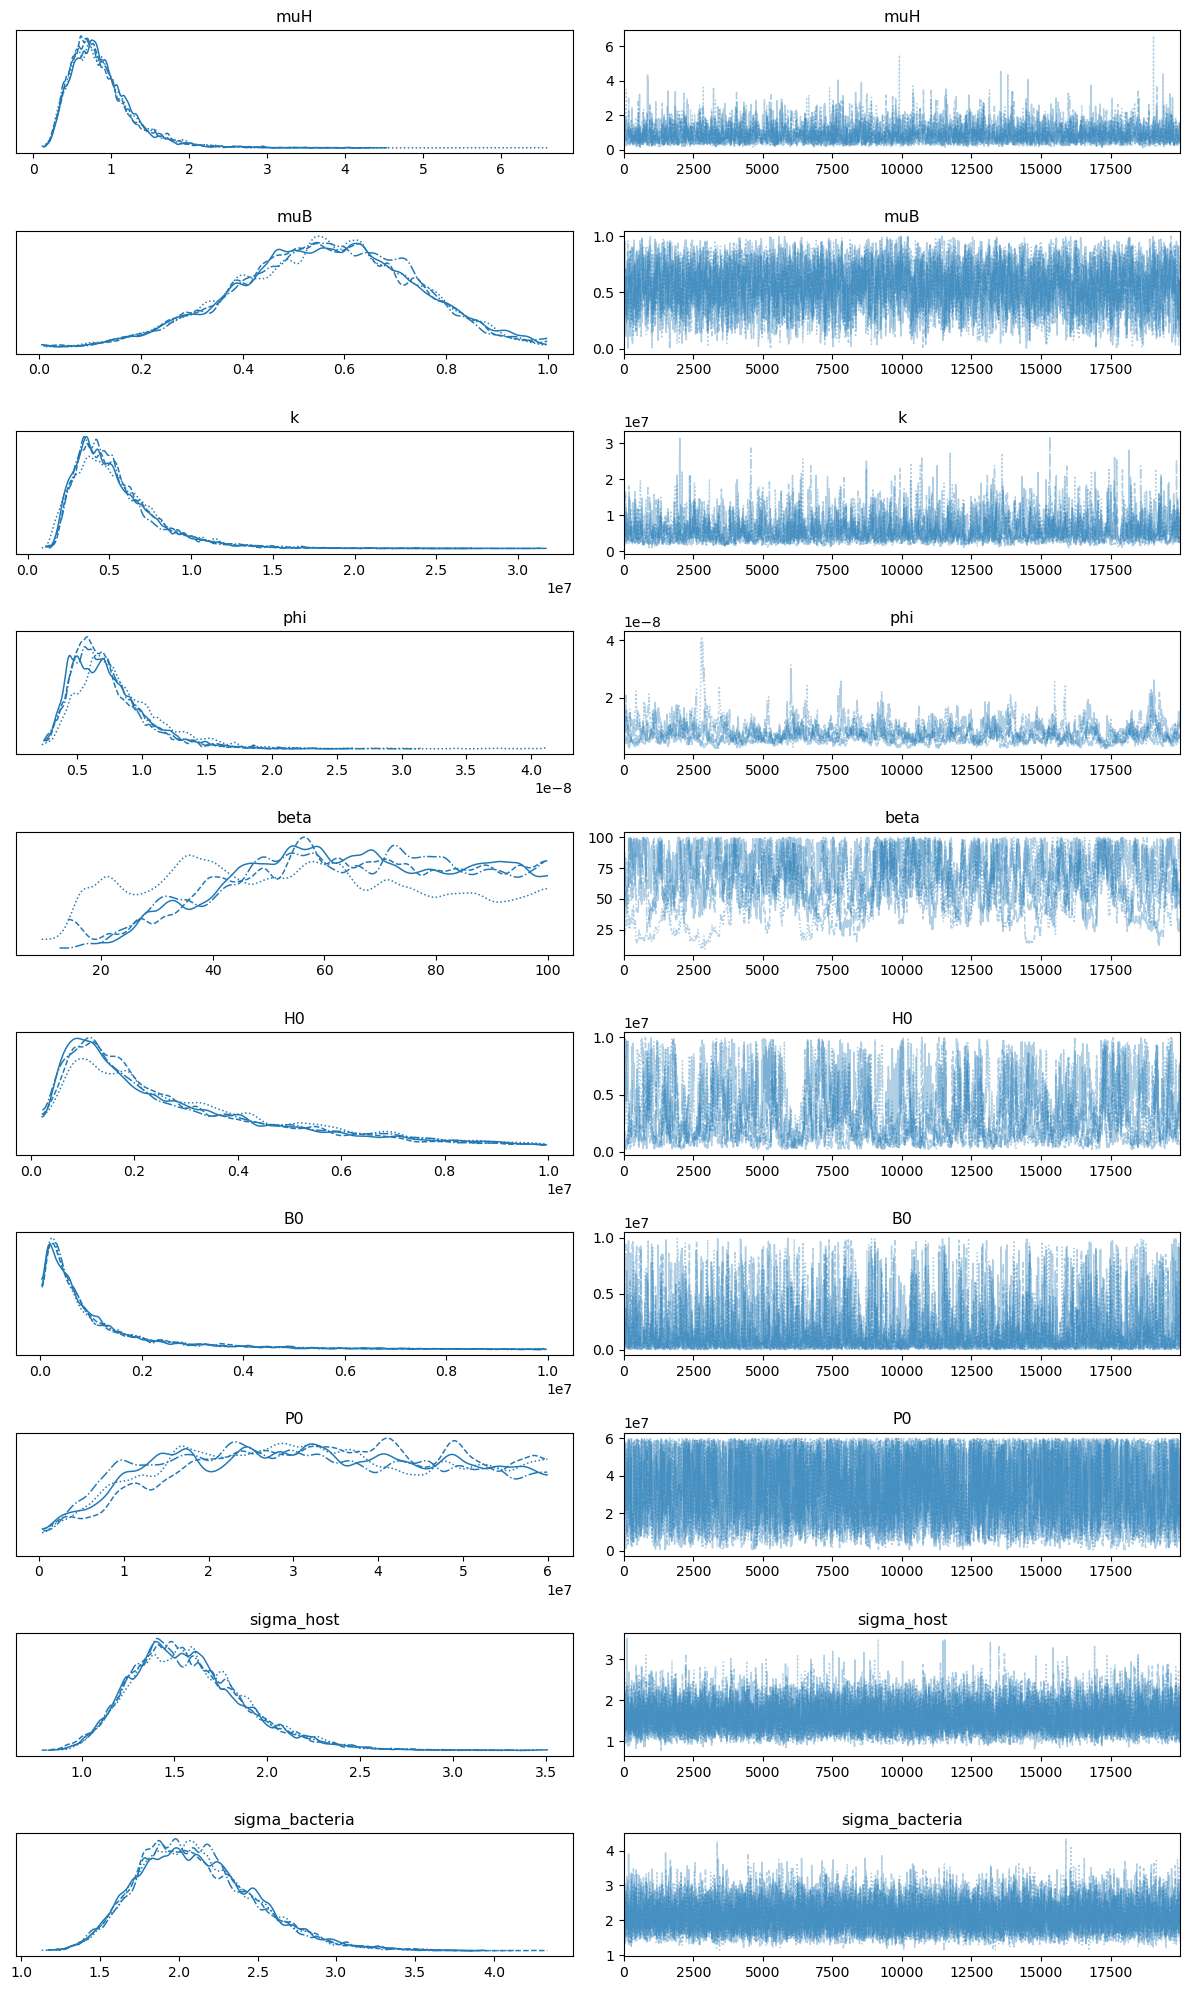

In [7]:
az.plot_trace(trace, 
              #var_names=["muH", "muB", "k", "phi", "beta", "gamma", "H0", "P0", "B0", "sigma_host", "sigma_pathogen", "sigma_bacteria"],
              backend_kwargs={"tight_layout": True})
plt.savefig(save_path + "-trace.png")
plt.show()

## SOME GPT5 Post Processing

In [8]:
def simulate_ode_from_posterior(
    idata,
    time,
    ode_rhs,
    n_draws=100,
    random_seed=None,
):
    import numpy as np
    import arviz as az
    from scipy.integrate import solve_ivp

    rng = np.random.default_rng(random_seed)

    posterior = idata.posterior
    n_chains = posterior.sizes["chain"]
    n_draws_posterior = posterior.sizes["draw"]

    flat_idx = rng.integers(0, n_chains * n_draws_posterior, size=n_draws)
    chain_idx = flat_idx // n_draws_posterior
    draw_idx = flat_idx % n_draws_posterior

    time = np.asarray(time, dtype=float)
    t_span = (time[0], time[-1])

    sims = []

    for c, d in zip(chain_idx, draw_idx):
        muH0 = float(posterior["muH"].values[c, d])
        muB0 = float(posterior["muB"].values[c, d])
        k0      = float(posterior["k"].values[c, d])
        phi0    = float(posterior["phi"].values[c, d])
        beta0  = float(posterior["beta"].values[c, d])

        H00 = float(posterior["H0"].values[c, d])
        P00 = float(posterior["P0"].values[c, d])
        B00 = float(posterior["B0"].values[c, d])

        params_vec = np.array([muH0, muB0, k0, phi0, beta0], dtype=float)
        y0 = [H00, B00, P00]

        sol = solve_ivp(
            lambda t, y: ode_rhs(t, y, params_vec),
            t_span=t_span,
            y0=y0,
            t_eval=time,
            method="LSODA",   # or whatever stiff solver you like
            rtol=1e-6,
            atol=1e-8,
        )

        if not sol.success:
            sims.append(np.full((time.size, 3), np.nan))
        else:
            sims.append(sol.y.T)

    sims = np.stack(sims, axis=0)  # (n_draws, T, 3)
    return sims


In [9]:
import matplotlib.pyplot as plt

def plot_posterior_fit(
    idata,
    time,
    host,
    #d7,
    bacteria,
    ode_rhs,
    n_draws=200,
    log_scale=True,
    random_seed=None,
):
    """
    Plot posterior ODE trajectories over the observed data
    for Host, D7/Pathogen, and Bacteria.
    """
    time = np.asarray(time, dtype=float)
    host = np.asarray(host, dtype=float)
    #d7 = np.asarray(d7, dtype=float)
    bacteria = np.asarray(bacteria, dtype=float)

    sims = simulate_ode_from_posterior(
        idata,
        time,
        ode_rhs,
        n_draws=n_draws,
        random_seed=random_seed,
    )  # (n_draws, T, 3)

    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 10))

    series = [host, bacteria]
    labels = ["Host", "Bacteria"]

    for i, ax in enumerate(axes):
        y_obs = series[i]
        y_sim = sims[:, :, i]  # (n_draws, T)

        if log_scale:
            y_obs_plot = np.log(y_obs + 1e-9)
            y_sim_plot = np.log(y_sim + 1e-9)
            ax.set_ylabel(f"log {labels[i]}")
        else:
            y_obs_plot = y_obs
            y_sim_plot = y_sim
            ax.set_ylabel(labels[i])

        # scatter observed data
        ax.scatter(time, y_obs_plot, marker="o", alpha=0.8)

        # posterior median and 90% band
        median = np.nanmedian(y_sim_plot, axis=0)
        lower, upper = np.nanpercentile(y_sim_plot, [5, 95], axis=0)

        ax.plot(time, median, linewidth=2)
        ax.fill_between(time, lower, upper, alpha=0.2)

        ax.grid(True, alpha=0.3)

    axes[-1].set_xlabel("Time")
    plt.tight_layout()
    return fig, axes


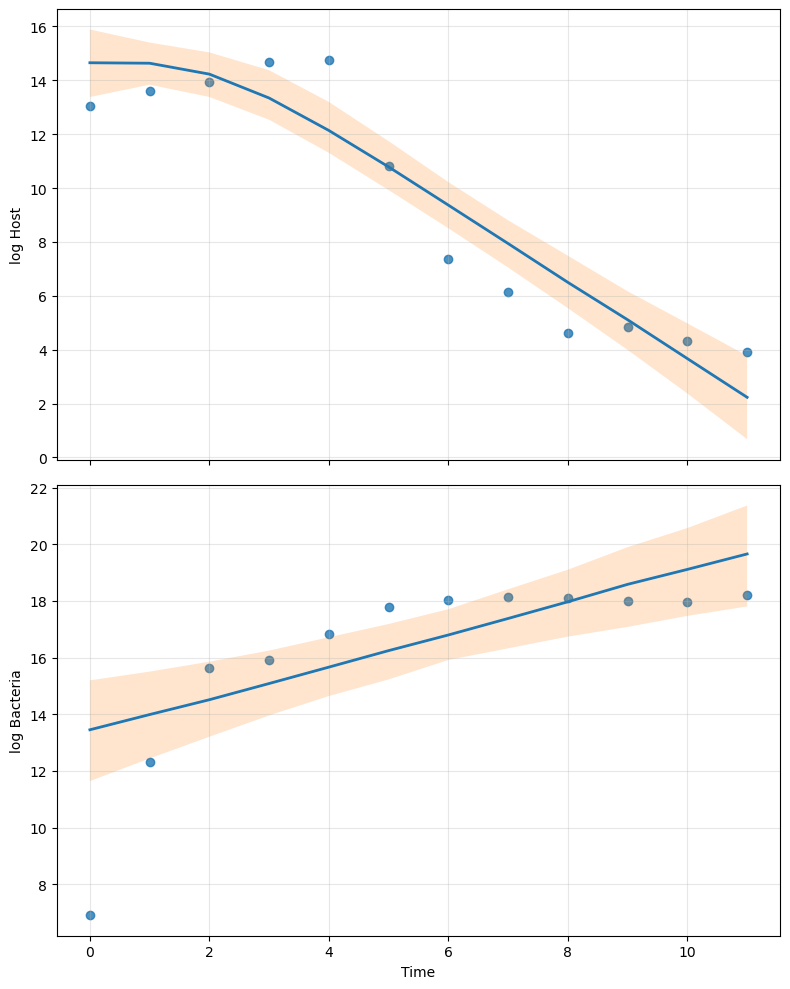

In [10]:
fig, axes = plot_posterior_fit(
    idata=trace,
    time=time,
    host=host,
    #d7=None,
    bacteria=bacteria,
    ode_rhs=ode_system,
    n_draws=200,
    log_scale=True,
    random_seed=42,
)
plt.savefig(save_path + "-posterior-fit.png")
plt.show()

In [11]:
import numpy as np
import pymc as pm

# 1) Ensure log_likelihood exists (compute once)
if "log_likelihood" not in trace.groups():
    with model:
        idata = pm.compute_log_likelihood(trace, progressbar=True)
else:
    print("log_likelihood already present; using existing idata.log_likelihood")

# 2) Sum log-likelihood across observed variables and observations
ll = trace.log_likelihood
total_ll = None
for v in ll.data_vars:
    term = ll[v]
    # sum across all non-(chain, draw) dims
    sum_dims = tuple(d for d in term.dims if d not in ("chain", "draw"))
    term_sum = term.sum(dim=sum_dims)
    total_ll = term_sum if total_ll is None else total_ll + term_sum

# 3) Find best (chain, draw)
stacked = total_ll.stack(sample=("chain", "draw"))
best_i = int(stacked.argmax("sample").values)

best_chain = int(stacked["chain"].values[best_i])
best_draw  = int(stacked["draw"].values[best_i])

print("Best posterior draw (by total log-likelihood):")
print("  chain =", best_chain)
print("  draw  =", best_draw)
print("  total log-likelihood =", float(stacked.values[best_i]))

# 4) Extract parameters at that draw
best_params = trace.posterior.isel(chain=best_chain, draw=best_draw)
#best_params

df = pd.DataFrame({
    "parameter": list(best_params.data_vars),
    "value": [
        float(best_params[var].values)
        for var in best_params.data_vars
    ]
})

df.to_csv(save_path + "-best_posterior_params.csv", index=False)
print("Saved best posterior parameters to best_posterior_params.csv")


Output()

Best posterior draw (by total log-likelihood):
  chain = 2
  draw  = 2027
  total log-likelihood = -46.73585890537012
Saved best posterior parameters to best_posterior_params.csv
